In [1]:
import spot
from buddy import bddtrue
spot.setup()

# Support for games

The support for games is currently quite rudimentary, as Spot currently only uses those games in `ltlsynt`.

In essence, agame is just an ω-automaton with a property named `state-player` that stores the player owning each state.  The players are named 0 and 1.  The player owning a state can decide what the next transition from this state should be.  The goal for player 1 is to force the play to be infinite and to satisfy the acceptance condition of the automaton, while the goal for player 0 is to prevent it by either forcing a finite play, or forcing an infinite play that does not satisfy the acceptance condition.

The support is currently restricted to games that use:
- `t` acceptance: all infinite run are accepting, and player 0 can only win if it manages to force a finite play (this requires reaching states without successors).
- max odd parity acceptance: player 0 can win if the maximal value seen infinitely often is even

# Creating games from scratch

Games can be [created like any automaton](https://spot.lrde.epita.fr/tut22.html).  
Using `set_state_players()` will fix the state owners.

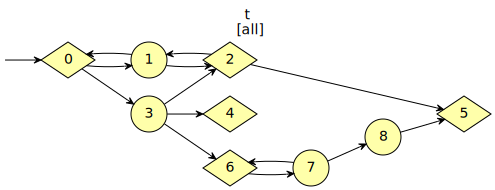

In [2]:
bdict = spot.make_bdd_dict();
game = spot.make_twa_graph(bdict)
game.new_states(9)
for (s, d) in ((0,1), (0, 3), 
               (1, 0), (1, 2),
               (2, 1), (2, 5),
               (3, 2), (3, 4), (3, 6),
               (6, 7),
               (7, 6), (7, 8),
               (8, 5)):
  game.new_edge(s, d, bddtrue)
spot.set_state_players(game, [True, False, True, False, True, True, True, False, False])
game.show('.g')  # Use "g" to hide the irrelevant edge labels.

The `set_state_players()` function takes a list of owner for each of the states in the automaton.  In the output,
states from player 0 use circles, ellispes, or rectangle with rounded corners (mnemonic: 0 is round) while states from player 1 have a losanse shape (1 has only straight lines). 


State ownership can also be manipulated by the following functions:

In [3]:
spot.get_state_players(game)

(True, False, True, False, True, True, True, False, False)

In [4]:
spot.get_state_player(game, 4)

True

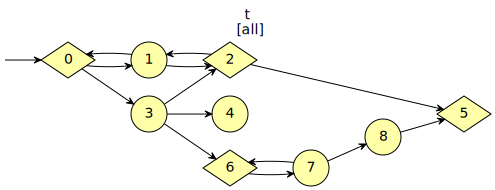

In [5]:
spot.set_state_player(game, 4, False)
game.show('.g')

# Solving a game - The "old" way

Solving a game is done my calling `solve_safety_game()` or `solve_parity_game()`.   This will attach two additional vectors into the game automaton: one vector stores the winner of each state, and one vector stores (memory-less) strategy for each state, i.e., the transition that should always be taken by the owner of this state in order to win.  

The return value of those function is simply the winner for the initial state.

In [6]:
spot.solve_safety_game(game)

True

Calling the `highlight_strategy()` function can be used to decorate the `game` automaton using the winning regions and strategies.  Below, green represent the winning region/strategy for player 1 and red those for player 0.

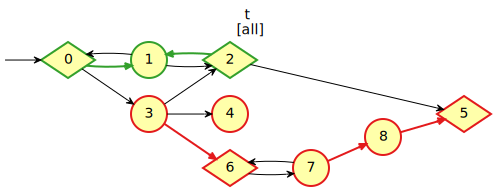

In [7]:
spot.highlight_strategy(game)
game.show('.g')

# Solving a game - The new interface

A strategy/control circuit can now be derived more conveniently from a LTL/PSL specification.
The process is decomposed in to three steps:
- Creating the game
- Solving the game
- Obtaining the strategy

Each of these steps is parametrized by the same options structure called game_info.

game has  29  states, and  55  edges.
output propositions are  ('o0',)


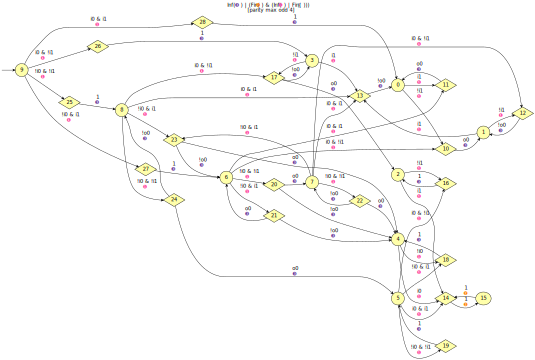

In [8]:
#Create the game
gi = spot.game_info()
gi.s = spot.game_info.solver_LAR #Use lar solver

#Todo arena changes when executed multiple times
game = spot.create_game("G((F(i0) && F(i1))->(G(i1<->(X(o0)))))", ["o0"], gi)
print("game has ", game.num_states(), " states, and ", game.num_edges(), " edges.")
print("output propositions are ", spot.get_synthesis_output_aps(game))
display(game)

Found a solution:  True


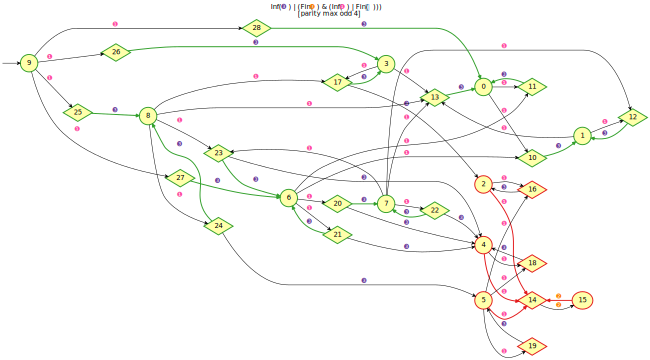

In [9]:
#Solve the game
print("Found a solution: ", spot.solve_game(game))
spot.highlight_strategy(game)
game.show('.g')

minimization lvl  0


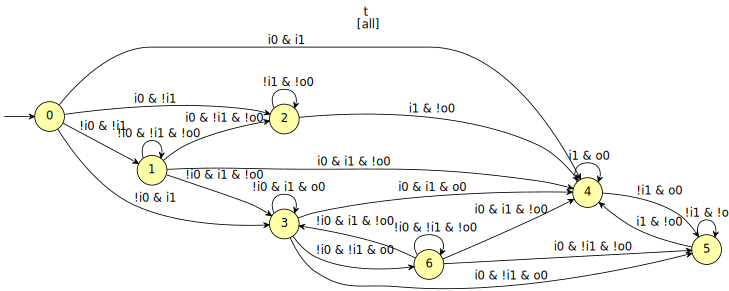

minimization lvl  1


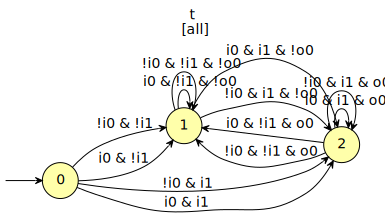

minimization lvl  2


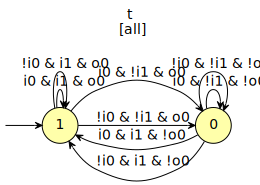

minimization lvl  3


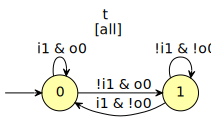

minimization lvl  4


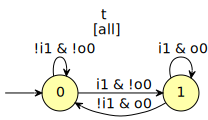

minimization lvl  5


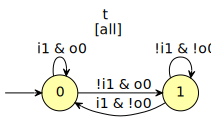

In [10]:
# Create the strategy
# We have different strategies for minimization:
# 0 : No minimizaiton
# 1 : DFA minimization
# 2 : Inclusion based minimization with output assignement
# 3 : SAT based exact minimization
# 4 : First 1 then 3 (exact)
# 5 : First 2 then 3 (not exact)
for i in range(6):
    print("minimization lvl ", i)
    gi.minimize_lvl = i #Use inclusion with output assignement to minimize the strategy
    strat = spot.create_strategy(game, gi)
    display(strat.show())

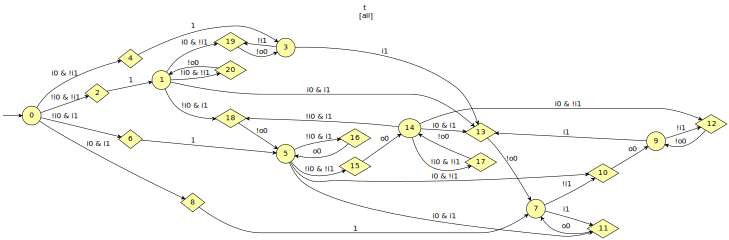

In [11]:
gi.minimize_lvl = 0
spot.apply_strategy(game, False, False)


## Input/Output

An extension of the HOA format makes it possible to store the `state-player` property.  This allows us to read the parity game constructed by `ltlsynt` using `spot.automaton()` like any other automaton.

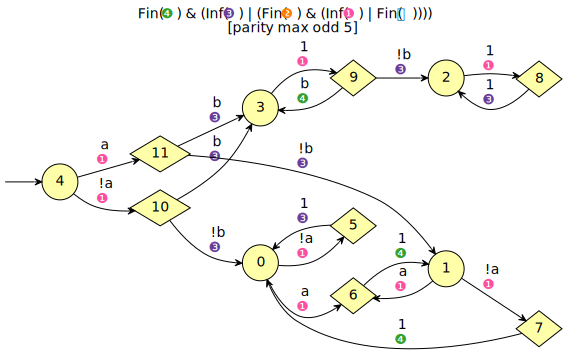

In [12]:
game = spot.automaton("ltlsynt --ins=a --outs=b -f '!b & GFa <-> Gb' --print-game-hoa |");
game

In the graphical output, player 0 is represented by circles (or ellipses or rounded rectangles depending on the situations), while player 1's states are diamond shaped.  In the case of `ltlsynt`, player 0 plays the role of the environment, and player 1 plays the role of the controler.

In the HOA output, a header `spot-state-player` (or `spot.state-player` in HOA 1.1) lists the owner of each state.

In [13]:
print(game.to_str('hoa'))

HOA: v1
States: 12
Start: 4
AP: 2 "b" "a"
acc-name: parity max odd 5
Acceptance: 5 Fin(4) & (Inf(3) | (Fin(2) & (Inf(1) | Fin(0))))
properties: trans-labels explicit-labels trans-acc colored complete
properties: deterministic
spot-state-player: 0 0 0 0 0 1 1 1 1 1 1 1
--BODY--
State: 0
[!1] 5 {1}
[1] 6 {1}
State: 1
[1] 6 {1}
[!1] 7 {1}
State: 2
[t] 8 {1}
State: 3
[t] 9 {1}
State: 4
[!1] 10 {1}
[1] 11 {1}
State: 5
[t] 0 {3}
State: 6
[t] 1 {4}
State: 7
[t] 0 {4}
State: 8
[t] 2 {3}
State: 9
[!0] 2 {3}
[0] 3 {4}
State: 10
[!0] 0 {3}
[0] 3 {3}
State: 11
[!0] 1 {3}
[0] 3 {3}
--END--


Here is the solution of this particular game.

In [14]:
spot.solve_parity_game(game)

True

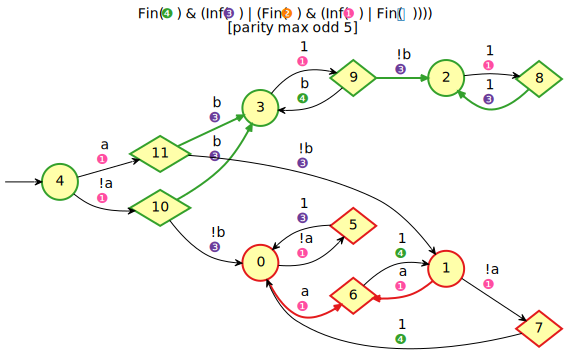

In [15]:
spot.highlight_strategy(game)

<h2>Reading an aiger-file</h2>

<p>Read an aiger file. Note that we do not support the full 
    <a href="http://fmv.jku.at/aiger/FORMAT.aiger">syntax</a>, but are restricted to:
    <ul>
        <li>Input variables start at index 2 and are consecutively numbered.</li>
        <li>Latch variables start at index (1 + #inputs) * 2 and are consecutively numbered.</li>
        <li>If inputs or outputs are named in the comments, all of them have to be named.</li>
        <li>Gate number $n$ can only have latches, inputs or previously defined gates ($<n$). </li>
    </ul>
</p>

In [16]:
#aiger file 
aag_txt = """aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 a
i1 b
o0 c
o1 d
"""
print(aag_txt)

aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 a
i1 b
o0 c
o1 d



In [17]:
this_aig = spot.aiger_circuit(aag_txt)

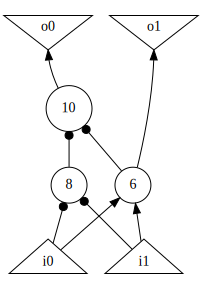

In [18]:
display(this_aig.show())

In [19]:
print(this_aig.to_str())

aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 i0
i1 i1
o0 o0
o1 o1



In [20]:
print(this_aig.gates())

((2, 4), (3, 5), (7, 9))


<h2>Verifying an implementation</h2>

<p>
    An aiger circuit can be transformed into a monitor. If the aiger represents the implementation of a strategy in the context of active control, it can be check for correctness. This is done by computing the intersecting of the monitor and the negation of the specification.
</p>

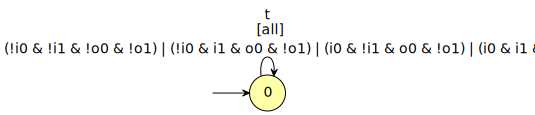

In [21]:
aigasmon = this_aig.as_automaton()
display(aigasmon)